In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model
from fourparam_fit import xi_bestfit

In [2]:
nmocks = 401
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
data_dir = '/scratch/aew492/research-summer2020_output/'

In [3]:
nbins = 22
ncont = 2000
rmin = 20.0
rmax = 140.0
rfine = np.linspace(rmin, rmax, ncont+1)

### lognormal

In [5]:
# gather results into arrays
# Landy-Szalay
xi_lss = np.empty((nmocks, nbins))
lstsq_fits = np.empty((nmocks, ncont+1))
lstsq_alphas = np.ones(nmocks)
baoit_fits = np.empty((nmocks, ncont))
baoit_alphas = np.ones(nmocks)

for rlz in range(nmocks):
    # Landy-Szalay, binned estimator
    xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = xi_ls[0]
    xi_lss[rlz] = xi_ls[1]
    
    # 4-parameter fit, standard
    lstsq_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/identity/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    B_sq = lstsq_results['B_sq']
    a1 = lstsq_results['a1']
    a2 = lstsq_results['a2']
    a3 = lstsq_results['a3']
    lstsq_alpha = lstsq_results['best_alpha']

    xi_mod_fine = cf_model(lstsq_alpha*rfine, cosmo_base=None, redshift=0.57, bias=2.0)
    xi_fit = xi_bestfit(rfine, xi_mod_fine, B_sq, a1, a2, a3)

    lstsq_fits[rlz] = xi_fit
    lstsq_alphas[rlz] = lstsq_alpha
    
    # bao iterative, CFE
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    baoit_alpha = extra_dict['alpha_model']
    
    baoit_fits[rlz] = bao_basis
    baoit_alphas[rlz] = baoit_alpha

In [6]:
# averages and standard deviations across all mocks
ls_avg = np.mean(xi_lss, axis=0)
ls_std = np.std(xi_lss, axis=0)
print(ls_avg.shape, ls_std.shape)
lstsq_avg = np.mean(lstsq_fits, axis=0)
lstsq_std = np.std(lstsq_fits, axis=0)
print(lstsq_avg.shape, lstsq_std.shape)
baoit_avg = np.mean(baoit_fits, axis=0)
baoit_std = np.std(baoit_fits, axis=0)
print(baoit_avg.shape, baoit_std.shape)

(22,) (22,)
(2001,) (2001,)
(2000,) (2000,)


In [7]:
# error regions (for 4-parameter and bao iterative fits)
lstsq_err_regions = [lstsq_avg-lstsq_std, lstsq_avg+lstsq_std]
baoit_err_regions = [baoit_avg-baoit_std, baoit_avg+baoit_std]

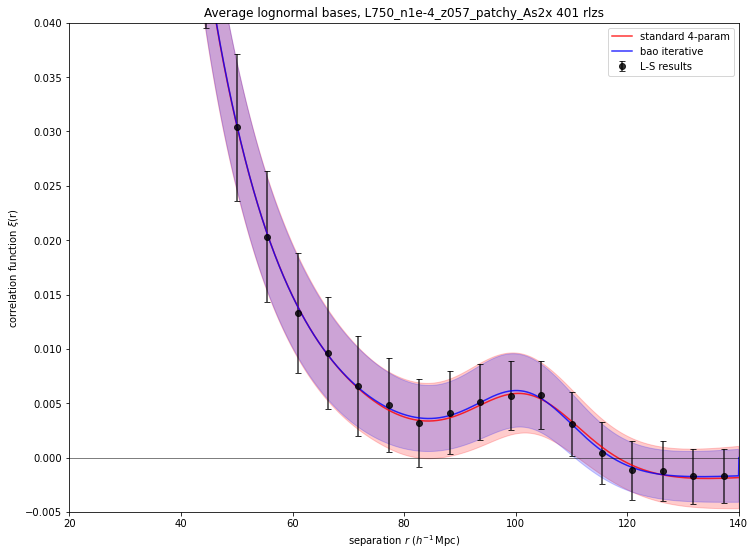

In [8]:
# plot
fig, ax = plt.subplots(figsize=(12,9))

# plt.plot(r_avg, ls_avg, marker='o', ls='None', alpha=0.8, label=f'L-S Results')
ax.errorbar(r_avg, ls_avg, yerr=ls_std, color='k', alpha=0.8, fmt='o', capsize=3, label=f'L-S results')

plt.plot(rfine, lstsq_avg, lw=1.5, alpha=0.8, color='r', label=f'standard 4-param')
ax.fill_between(rfine, lstsq_err_regions[0], lstsq_err_regions[1], color='r', alpha=0.2)

plt.plot(rcont, baoit_avg, lw=1.5, alpha=0.8, color='b', label='bao iterative')
ax.fill_between(rcont, baoit_err_regions[0], baoit_err_regions[1], color='b', alpha=0.2)

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Average lognormal bases, {cat_tag} 401 rlzs')
plt.legend()

In [9]:
print("Landy_Szalay std = ", ls_std.shape, ls_std)
print("standard 4-parameter fit std = ", lstsq_std.shape, lstsq_std)
print("CFE bao iterative fit std = ", baoit_std.shape, baoit_std)

Landy_Szalay std =  (22,) [0.01759598 0.01325184 0.0103152  0.00875332 0.0077369  0.0067544
 0.00603605 0.00555642 0.0051531  0.00457861 0.00428222 0.00407903
 0.00380874 0.0034813  0.00319366 0.00314344 0.0029298  0.002865
 0.00274366 0.00274718 0.00256178 0.00245909]
standard 4-parameter fit std =  (2001,) [0.02452407 0.02428729 0.02405515 ... 0.00286939 0.00287094 0.00287249]
CFE bao iterative fit std =  (2000,) [0.02550314 0.02530494 0.02510922 ... 0.00243198 0.00243295 0.        ]


## creating the covariance matrix

### numpy

In [13]:
# covariances in L-S
cov = np.cov(xi_lss.T)
cov.shape

(22, 22)

In [14]:
var = np.diag(cov)
var.shape

(22,)

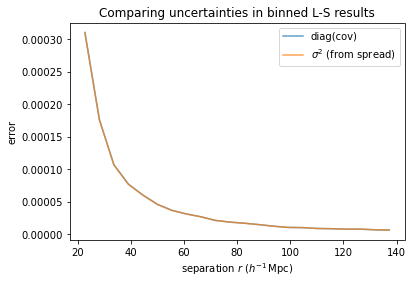

In [24]:
fig, ax = plt.subplots()
alpha = 0.7

plt.plot(r_avg, var, alpha=alpha, label='diag(cov)')
plt.plot(r_avg, ls_std**2, alpha=alpha, label=r'$\sigma^2$ (from spread)')
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'error')
ax.set_title('Comparing uncertainties in binned L-S results')
plt.legend()

### writing my own cov function